In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle

import torch
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
#from torchsummary import summary
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import tqdm
from timeit import default_timer as timer
from torch import Tensor, nn
from torch.nn.functional import interpolate


In [2]:
from ElasticDataset import PickleSeriesDataset

In [3]:
batch_size = 4092

In [4]:
#Dataloader iterators
dataloaders = {
    'train': DataLoader(
        PickleSeriesDataset('X_train', 'y_train', return_img=False), 
        batch_size=batch_size,
        shuffle=False,
        num_workers=5,
    ),
    'val': DataLoader(
        PickleSeriesDataset('X_valid', 'y_valid', return_img=False),
        batch_size=batch_size, 
        shuffle=False,
        num_workers=5,
    ),
    'test': DataLoader(
        PickleSeriesDataset('X_test', 'y_test', return_img=False),
        batch_size=batch_size, 
        shuffle=False,
        num_workers=5,
    )
}

LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_train.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_train.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_valid.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_valid.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_test.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_test.pkl


## Model

In [5]:
class MulticlassClassification(nn.Module):
    def __init__(self, cat_size, num_col, output_size, layers, p=0.4):
        super(MulticlassClassification, self).__init__()
        
        # TABULAR: 
        self.all_embeddings = nn.ModuleList(
            [nn.Embedding(categories, size) for categories, size in cat_size]
        )
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_col)

        all_layers = []
        num_cat_col = sum(e.embedding_dim for e in self.all_embeddings)
        input_size = num_cat_col + num_col

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i, embedding in enumerate(self.all_embeddings):
            embeddings.append(embedding(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        x = self.logsoftmax(x)
        
        return x

In [7]:
pickle_dir = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\'
def load_pickle(name):
    with open(pickle_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
categorical_embedding_sizes = load_pickle('categorical_embedding_sizes')

In [8]:
from torch import cuda, optim

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


In [9]:
model = MulticlassClassification(categorical_embedding_sizes, 4, 20, [512, 128, 64], p=0.2).to('cuda')
model

MulticlassClassification(
  (all_embeddings): ModuleList(
    (0): Embedding(4096, 50)
    (1): Embedding(2, 1)
    (2): Embedding(4096, 50)
    (3): Embedding(4096, 50)
    (4): Embedding(3, 2)
    (5): Embedding(30, 15)
    (6): Embedding(4096, 50)
    (7): Embedding(4096, 50)
    (8): Embedding(4, 2)
    (9): Embedding(2, 1)
    (10): Embedding(2, 1)
    (11): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.2, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=277, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)


In [10]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
save_file_name = 'C:\\NFT_data\\networks\\nn_tabular_data_softmax.pt'
checkpoint_path = 'C:\\NFT_data\\networks\\nn_tabular_data_softmax.pth'

In [12]:
#save_file_name = 'C:\\NFT_data\\networks\\nn_tabular_data.pt'
#checkpoint_path = 'C:\\NFT_data\\networks\\nn_tabular_data.pth'

In [13]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=50,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (stack_cat, stack_num, target) in enumerate(train_loader):
            #print(data)
            #print(img)

            # Tensors to gpu
            if train_on_gpu:
                stack_cat, stack_num, target = stack_cat.cuda(), stack_num.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(stack_cat, stack_num)
            
            #output = torch.cat((output_img, output_tab), dim=1)
            #output = self.relu(output)
            #m = nn.Softmax(dim=1)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * stack_cat.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * stack_cat.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for ii, (stack_cat, stack_num, target) in enumerate(valid_loader):
                    # Tensors to gpu
                    if train_on_gpu:
                        stack_cat, stack_num, target = stack_cat.cuda(), stack_num.cuda(), target.cuda()

                    # Forward pass
                    output = model(stack_cat, stack_num)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * stack_cat.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * stack_cat.size(0)
                    
                    # Track validation progress
                    print(
                        f'Epoch: {epoch}\t{100 * (ii + 1) / len(valid_loader):.2f}% validated. {timer() - start:.2f} seconds elapsed in epoch.',
                        end='\r')

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    valid_acc = history[best_epoch][3]
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [14]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=70,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	105.63% validated. 434.69 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.7465 	Validation Loss: 1.5566
		Training Accuracy: 36.13%	 Validation Accuracy: 39.92%
Epoch: 1	105.63% validated. 429.36 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.5251 	Validation Loss: 1.4810
		Training Accuracy: 41.65%	 Validation Accuracy: 42.77%
Epoch: 2	105.63% validated. 431.03 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.4744 	Validation Loss: 1.4449
		Training Accuracy: 43.51%	 Validation Accuracy: 44.72%
Epoch: 3	105.63% validated. 429.81 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.4423 	Validation Loss: 1.4265
		Training Accuracy: 44.83%	 Validation Accuracy: 45.55%
Epoch: 4	105.63% validated. 432.62 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.4197 	Validation Loss: 1.4162
		Training Accuracy: 45.71%	 Validation Accuracy: 45.87%
Epoch: 5	105.63% validated. 428.36 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.4003

In [14]:
# with softmax
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=70,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	105.63% validated. 381.90 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.7541 	Validation Loss: 1.5685
		Training Accuracy: 35.98%	 Validation Accuracy: 39.58%
Epoch: 1	105.63% validated. 384.62 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.5288 	Validation Loss: 1.4851
		Training Accuracy: 41.57%	 Validation Accuracy: 42.69%
Epoch: 2	105.63% validated. 414.40 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.4793 	Validation Loss: 1.4459
		Training Accuracy: 43.36%	 Validation Accuracy: 44.72%
Epoch: 3	105.63% validated. 408.15 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.4482 	Validation Loss: 1.4423
		Training Accuracy: 44.56%	 Validation Accuracy: 44.84%
Epoch: 4	105.63% validated. 403.67 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.4261 	Validation Loss: 1.4177
		Training Accuracy: 45.43%	 Validation Accuracy: 46.11%
Epoch: 5	105.63% validated. 398.52 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.4051

In [15]:
model.idx_to_class = ['0.0-1.0',
 '1.0-1.7',
 '1.7-3.0',
 '3.0-5.3',
 '5.3-9.1',
 '9.1-15.9',
 '15.9-27.7',
 '27.7-48.1',
 '48.1-83.7',
 '83.7-145.5',
 '145.5-253.0',
 '253.0-440.1',
 '440.1-765.3',
 '765.3-1331.0',
 '1331.0-2314.6',
 '2314.6-4025.3',
 '4025.3-7000.4',
 '7000.4-12174.3',
 '12174.3-21172.1',
 '21172.1-36820.0']

model.class_to_idx = {'0.0-1.0': 0,
 '1.0-1.7': 1,
 '1.7-3.0': 2,
 '3.0-5.3': 3,
 '5.3-9.1': 4,
 '9.1-15.9': 5,
 '15.9-27.7': 6,
 '27.7-48.1': 7,
 '48.1-83.7': 8,
 '83.7-145.5': 9,
 '145.5-253.0': 10,
 '253.0-440.1': 11,
 '440.1-765.3': 12,
 '765.3-1331.0': 13,
 '1331.0-2314.6': 14,
 '2314.6-4025.3': 15,
 '4025.3-7000.4': 16,
 '7000.4-12174.3': 17,
 '12174.3-21172.1': 18,
 '21172.1-36820.0': 19}

def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if multi_gpu:
        checkpoint['state_dict'] = model.module.state_dict()
    else:
        checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)


In [16]:
save_checkpoint(model, path=checkpoint_path)

In [ ]:
def load_checkpoint(model, path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Load in checkpoint
    checkpoint = torch.load(path)

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)
    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [18]:
model, optimizer = load_checkpoint(model, checkpoint_path)

## Evaluation

In [21]:
def evaluate(model, test_loader, criterion, topk=(1, 3, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """
    confusion_matrix = torch.zeros(20, 20)
    classes = []
    losses = []
    estimated_len = len(test_loader.dataset)
    # Hold accuracy results
    acc_results = np.zeros((estimated_len, len(topk)))
    i = 0
    start = timer()
    
    print(f'Starting Evaluatation.\n')

    model.eval()
    with torch.no_grad():

        # Testing loop      
        for stack_cat, stack_num, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                stack_cat, stack_num, targets = stack_cat.cuda(), stack_num.cuda(), targets.cuda()
        
            # Raw model output
            out = model(stack_cat, stack_num)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, 20), true.view(1))
                losses.append(loss.item())
                i += 1
            
                # Track progress
                print(
                    f'i: {i} / {estimated_len} evaluated. {timer() - start:.2f} seconds elapsed.',
                    end='\r')

    # Send results to a dataframe and calculate average across classes
    diff_len =  estimated_len - i
    acc_results = acc_results[:-diff_len]
    print(f'\n{len(acc_results)}')
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}), confusion_matrix

criterion = nn.CrossEntropyLoss()
# Evaluate the model on all the training data
results,confusion_matrix = evaluate(model, dataloaders['test'], criterion)

Starting Evaluatation.

i: 287199 / 287199 evaluated. 399.40 seconds elapsed.
0


In [19]:
testloader = dataloaders['test']

In [22]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

testiter = iter(testloader)
# Get a batch of testing images and labels
stack_cat, stack_num, target = next(testiter)

if train_on_gpu:
    res = accuracy(model(stack_cat.cuda(), stack_num.cuda()), target, topk=(1, ))
else:
    res = accuracy(model(stack_cat.cuda(), stack_num.cuda()), target, topk=(1, 5))
print(res)

[48.04496765136719]


Confusion matrix, without normalization


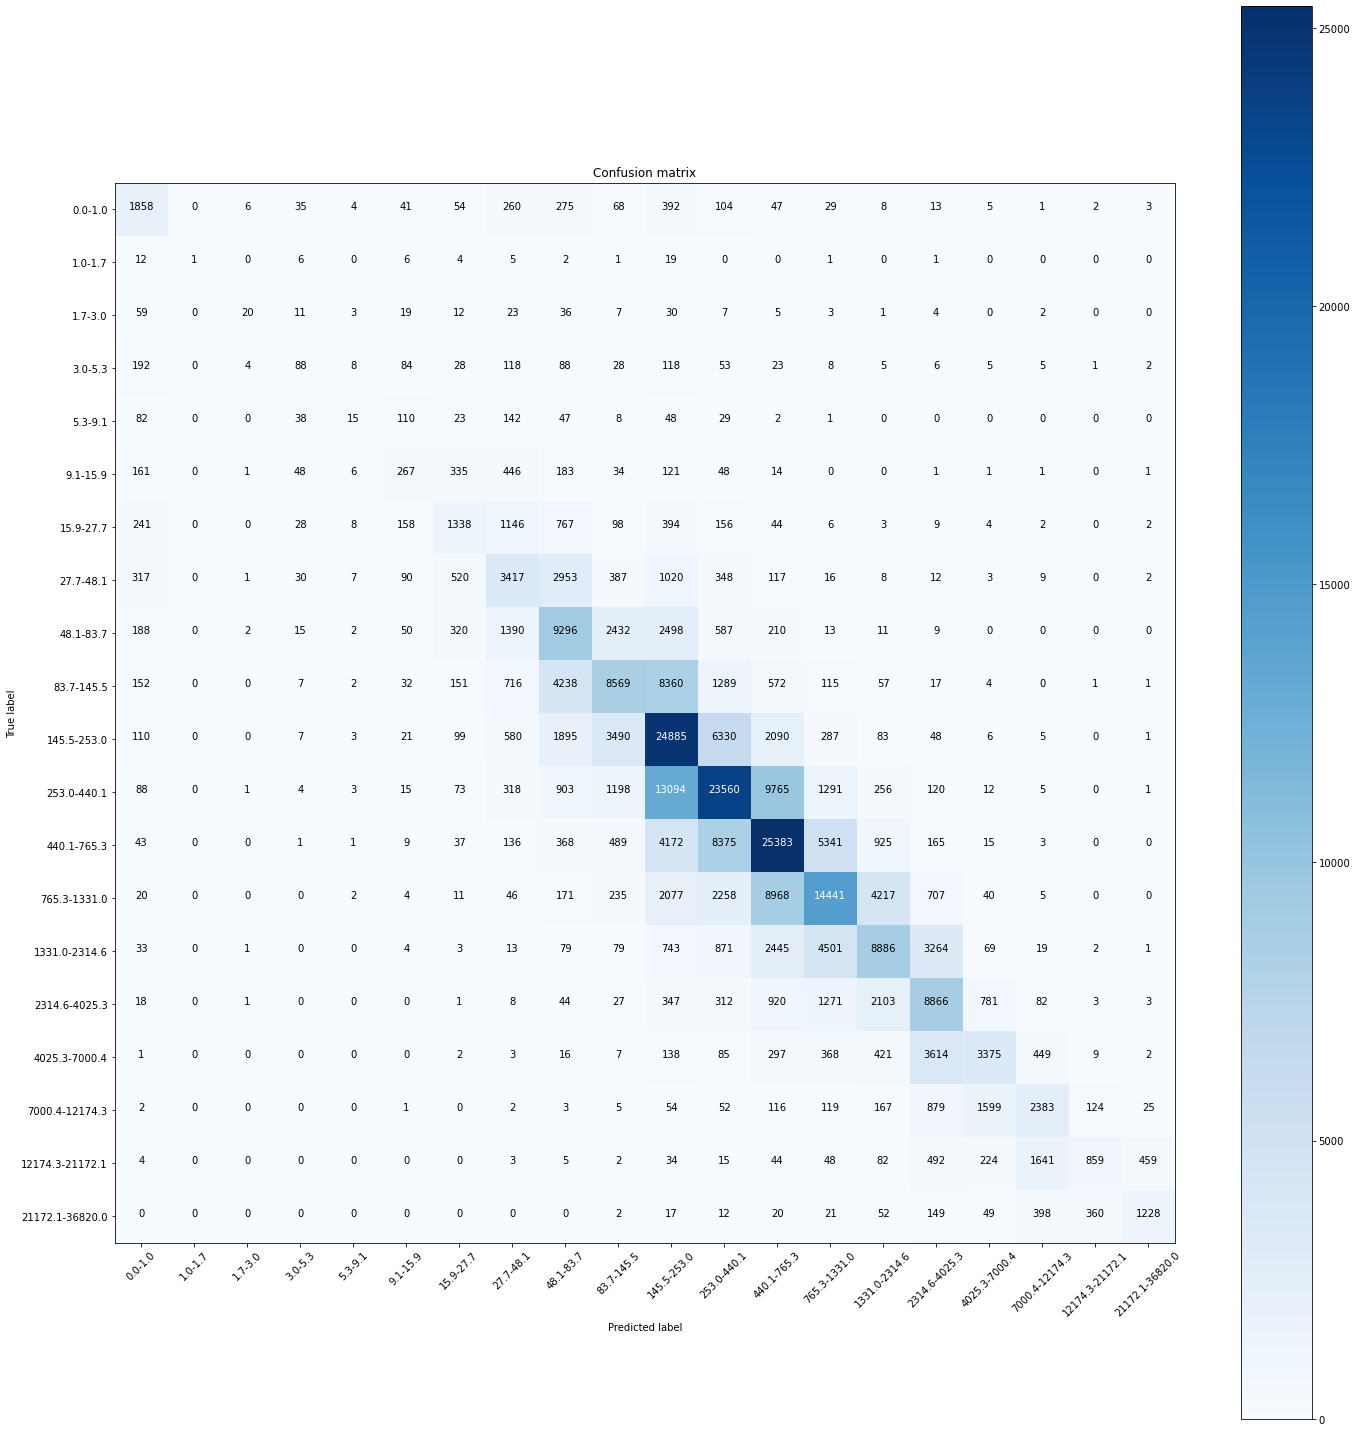

In [23]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'outputs/confusion_matrix.png')
    return plt

classnames = [model.idx_to_class[i] for i in range(0, 20)]

plt.figure(figsize=(20,20))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [3]:
import pickle

pickle_dir = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\'

def load_pickle(name):
    print('LOADING: ' + pickle_dir + name + '.pkl')
    with open(pickle_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_pkl(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

x_t = load_pickle('X_train')
save_pkl(x_t[0:100], 'X_train.sample')
#'y_train'
#'X_valid',
#'y_valid',
#'X_test',
#'y_test',
x_v = load_pickle('X_valid')
save_pkl(x_v[0:100], 'X_valid.sample')

x_test = load_pickle('X_test')
save_pkl(x_test[0:100], 'X_test.sample')

y_t = load_pickle('y_train')
save_pkl(y_t[0:100], 'y_train.sample')

y_v = load_pickle('y_valid')
save_pkl(y_v[0:100], 'y_valid.sample')

y_test = load_pickle('y_test')
save_pkl(y_test[0:100], 'y_test.sample')

LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_train.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_valid.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_test.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_train.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_valid.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_test.pkl


In [23]:
import os

def copy_image(path):
    if path.startswith('..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'):
        path_part = path[len('..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'):]
        path = 'E:\\data\\opensea\\' + path_part
    filename = path[path.rindex('\\'):]
    target = f'C:\\nft_data\\sample\\{filename}'
    os.system(f'copy {path} {target}')

In [24]:
x_test[0:100]['image_path'].apply(lambda row: copy_image(row))

716067    None
506943    None
643195    None
535597    None
17777     None
          ... 
260462    None
822487    None
504982    None
628443    None
78090     None
Name: image_path, Length: 100, dtype: object

In [25]:
x_t[0:100]['image_path'].apply(lambda row: copy_image(row))

913660     None
228961     None
354204     None
866830     None
992030     None
           ... 
1045781    None
637655     None
237783     None
921751     None
351360     None
Name: image_path, Length: 100, dtype: object

In [26]:
x_v[0:100]['image_path'].apply(lambda row: copy_image(row))

453052     None
1063738    None
1061359    None
1074393    None
310077     None
           ... 
374537     None
1058183    None
571652     None
56726      None
939778     None
Name: image_path, Length: 100, dtype: object

In [28]:
x_t = load_pickle('X_train.sample')
x_v = load_pickle('X_valid.sample')
x_test = load_pickle('X_test.sample')


y_t = load_pickle('y_train.sample')
y_v = load_pickle('y_valid.sample')
y_test = load_pickle('y_test.sample')


LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_train.sample.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_valid.sample.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_test.sample.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_train.sample.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_valid.sample.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_test.sample.pkl


In [29]:
x_v['image_path'].apply(lambda row: copy_image(row))
x_t['image_path'].apply(lambda row: copy_image(row))
x_test['image_path'].apply(lambda row: copy_image(row))

716067    None
506943    None
643195    None
535597    None
17777     None
          ... 
260462    None
822487    None
504982    None
628443    None
78090     None
Name: image_path, Length: 100, dtype: object

In [31]:
x_test['image_path'].iloc[0]

'C:\\nft_data\\preview\\71PbXn4B3CmUIj-JVeIs_noext.png'

## Captum

In [28]:
# Initial imports
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

from scipy import stats
import pandas as pd

In [29]:
model.eval()

MulticlassClassification(
  (all_embeddings): ModuleList(
    (0): Embedding(4096, 50)
    (1): Embedding(2, 1)
    (2): Embedding(4096, 50)
    (3): Embedding(4096, 50)
    (4): Embedding(3, 2)
    (5): Embedding(30, 15)
    (6): Embedding(4096, 50)
    (7): Embedding(4096, 50)
    (8): Embedding(4, 2)
    (9): Embedding(2, 1)
    (10): Embedding(2, 1)
    (11): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.2, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=277, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)


In [ ]:
testiter = iter(testloader)
# Get a batch of testing images and labels
stack_cat, stack_num, target = next(testiter)

In [32]:
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [33]:
embedding_inp = [embedding(stack_cat.cuda()[:,i]) for i, embedding in enumerate(model.all_embeddings)]

In [34]:
embeddings_cat = torch.cat(embedding_inp, 1)

In [35]:
interp_embeddings = []
for i in range(len(model.all_embeddings)):
    interp_embeddings.append(configure_interpretable_embedding_layer(model, 'all_embeddings.' + str(i)))

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\captum\attr\_models\base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [36]:
ig = IntegratedGradients(model)
ig.attribute(inputs=(embeddings_cat.cuda(), stack_num.cuda()), target=target.cuda())

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)